In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing Data

In [2]:
df = pd.read_csv(r"D:\Study\BA\train.csv")

### Checking the Data

In [3]:
df.describe()

,Row ID,Postal Code,Sales
count,9800.000000,9789.000000,9800.000000
mean,4900.500000,55273.322403,230.769059
std,2829.160653,32041.223413,626.651875
min,1.000000,1040.000000,0.444000
25%,2450.750000,23223.000000,17.248000
50%,4900.500000,58103.000000,54.490000
75%,7350.250000,90008.000000,210.605000
max,9800.000000,99301.000000,22638.480000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [5]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,7981,CA-2015-103800,03-01-2015,07-01-2015,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,Texas,77095.0,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448
1,740,CA-2015-112326,04-01-2015,08-01-2015,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540.0,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784
2,741,CA-2015-112326,04-01-2015,08-01-2015,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540.0,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736
3,742,CA-2015-112326,04-01-2015,08-01-2015,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540.0,Central,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540
4,1760,CA-2015-141817,05-01-2015,12-01-2015,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,Pennsylvania,19143.0,East,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536


In [6]:
df.shape

(9800, 18)

### Setting up the Time Data with Date as an index and summing up in montly format

In [7]:
df["Date"] = pd.to_datetime(df["Order Date"])

In [8]:
df = df.set_index("Date")

In [9]:
ts = pd.DataFrame(df.Sales.resample("M").sum())

In [10]:
ts.tail()

,Sales
Date,
2018-08-31,75408.7840
2018-09-30,73153.3640
2018-10-31,65501.1622
2018-11-30,87997.6400
2018-12-31,56959.2358


In [11]:
ts.shape

(48, 1)

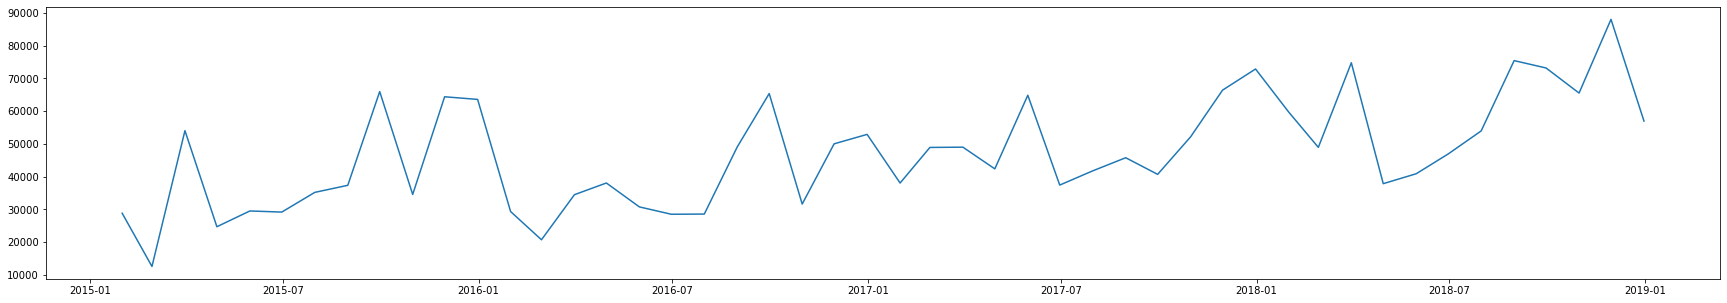

In [12]:
plt.figure(figsize=(30,5))
plt.plot(ts)

### Checking the stationarity with Dicky Fuller Test

In [13]:
from statsmodels.tsa.stattools import adfuller
dtest = adfuller(ts)
print('P-Value: %f' % dtest[1])

P-Value: 0.696763


### P value is more than 0.05 hence Conversion require, Log Transformation and Diffrancing needed

In [14]:
ts_log = np.log(ts)

In [15]:
ts_log_diff = ts_log - ts_log.shift(1)
ts_log_diff = ts_log_diff.dropna(axis=0)

In [16]:
dtest = adfuller(ts_log_diff)
print('P-Value: %f' % dtest[1])

P-Value: 0.000068


### Checking Decompose

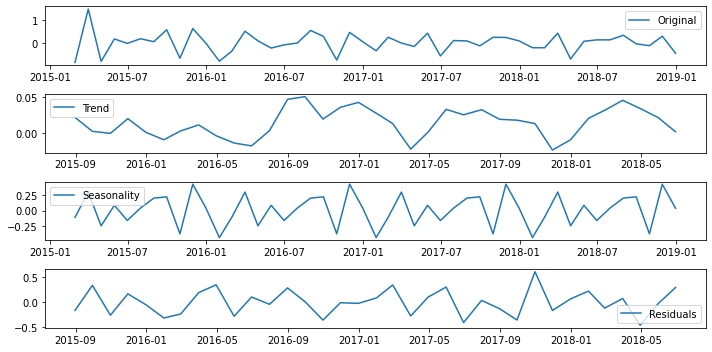

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log_diff)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(10,5))
plt.subplot(411)
plt.plot(ts_log_diff, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Trend seems to be more stable but increasing in long term, Seasonality seems to touch the peak during the december times

### Checking ACF and PACF for p and q parameters

In [18]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#### P which is the Partial Autocorrelation

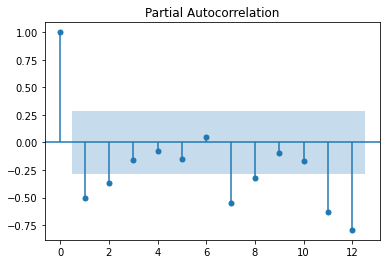

In [19]:
PACF = plot_pacf(ts_log_diff,lags=12)

#### Q which is the Partial Autocorrelation

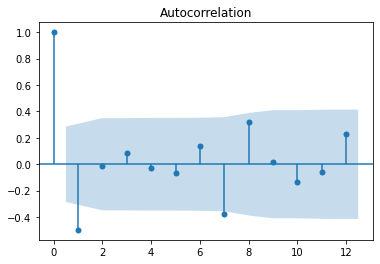

In [20]:
ACF = plot_acf(ts_log_diff,lags=12)

### Both ACF And PACF seems to have good correlation at 7th lag

### calling Library

In [643]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from pandas.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset

### Spliting the data from 48 months to 38:10 to check the accuracy of the model

In [22]:
train, test = train_test_split(ts,test_size=0.20,shuffle=False)

In [23]:
train.shape,test.shape

((38, 1), (10, 1))

### MAPE Score
##### <0.10 Highly Accurate
##### 0.10 - 0.20 Good
##### 0.20 - 0.50 Reasonable Forecasting
##### >0.50 Inaccurate

# Using Auto_ARIMA

In [27]:
from pmdarima import auto_arima

In [452]:
Auto = auto_arima(train,alpha=0.05,
                  start_p=0,d=1,start_q=0,
                  max_p=8,max_d=1,max_q=8,
                  start_P=0,D=1,start_Q=0,
                  max_P=8,max_D=1,max_Q=8,
                  m=12,
                 trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=564.542, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=558.450, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=562.020, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=556.181, Time=0.09 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=558.173, Time=0.22 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=558.173, Time=0.18 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=557.232, Time=0.07 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=560.174, Time=0.26 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=558.132, Time=0.09 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=556.646, Time=0.11 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=555.823, Time=0.18 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=558.752, Time=0.06 sec
 ARIMA(1,1,1)(3,1,0)[12]             : AIC=557.816, Time=0.31 sec
 ARIMA(1,1,1)(2,1,1)[12]             

In [453]:
Auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   38
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -273.144
Date:                             Mon, 02 May 2022   AIC                            554.287
Time:                                     13:28:31   BIC                            559.163
Sample:                                          0   HQIC                           555.640
                                              - 38                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4361      0.221     -1.976      0.048      -0.869      -0.004
ar.S.L12      -0.6875      0.323     -2.131      0.033      -1.320      -0.055
ar.S.L24      -0.4179      0.286     -1.461      0.144      -0.979       0.143
sigma2      2.582e+08   4.53e-10   5.71e+17      0.000    2.58e+08    2.58e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):                 1.38
Prob(Q):                              0.40   Prob(JB):                         0.50
Heteroskedasticity (H):               1.19   Skew:                             0.39
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.41e+33. Standard errors may be unstable.
"""

<AxesSubplot:>

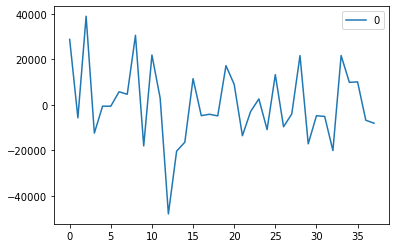

In [454]:
pd.DataFrame(Auto.resid()).plot()

<AxesSubplot:ylabel='Density'>

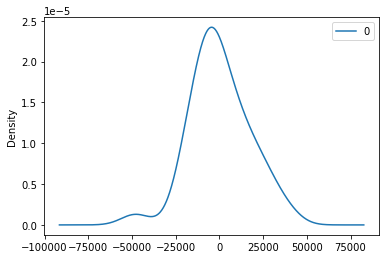

In [455]:
pd.DataFrame(Auto.resid()).plot(kind="kde")

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

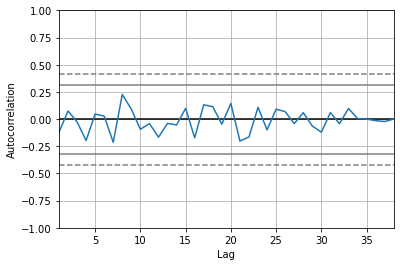

In [456]:
autocorrelation_plot(pd.DataFrame(Auto.resid()))

In [457]:
PreAUTO = pd.DataFrame(Auto.predict(n_periods=10),index=test.index)
PreAUTO.columns = ["AUTO_ARIMA RESULT"]

In [458]:
print("Auto_ARIMA",MAPE(test,PreAUTO))

Auto_ARIMA 0.24451569962602887


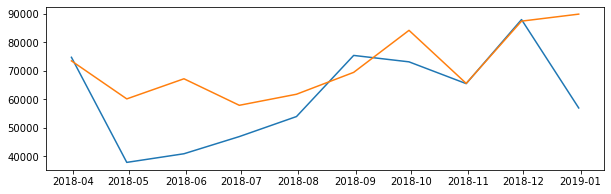

In [459]:
plt.figure(figsize=(10,3))
plt.plot(test)
plt.plot(PreAUTO)

In [649]:
concat0 = [PreAUTO,test]

In [650]:
pd.concat(concat0,axis=1)

,AUTO_ARIMA RESULT,Sales
Date,,
2018-03-31,73502.824497,74748.6238
2018-04-30,60143.892645,37849.2156
2018-05-31,67208.624192,40882.4464
2018-06-30,57895.136124,46912.8475
2018-07-31,61778.842505,53942.7755
2018-08-31,69458.846143,75408.7840
2018-09-30,84215.617457,73153.3640
2018-10-31,65587.633916,65501.1622
2018-11-30,87447.064720,87997.6400


In [675]:
F_D=pd.Series(pd.date_range("12/31/2018", freq="M", periods=11))
F_Date=pd.DataFrame(index=F_D[1:])

In [676]:
pd.DataFrame(Auto.predict(10),columns=["Auto_ARIMA"],index=F_Date.index)

,Auto_ARIMA
2019-01-31,73502.824497
2019-02-28,60143.892645
2019-03-31,67208.624192
2019-04-30,57895.136124
2019-05-31,61778.842505
2019-06-30,69458.846143
2019-07-31,84215.617457
2019-08-31,65587.633916
2019-09-30,87447.064720
2019-10-31,89906.593723


# Using ARIMA

In [677]:
from statsmodels.tsa.arima_model import ARIMA

In [678]:
M_ARIMA = ARIMA(train,order=(7,1,0))
ARIMA_M = M_ARIMA.fit()

In [679]:
ARIMA_M.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                   37
Model:                 ARIMA(7, 1, 0)   Log Likelihood                -402.472
Method:                       css-mle   S.D. of innovations          12377.982
Date:                Mon, 02 May 2022   AIC                            822.944
Time:                        14:09:23   BIC                            837.443
Sample:                    02-28-2015   HQIC                           828.056
                         - 02-28-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           728.4781    583.637      1.248      0.212    -415.430    1872.386
ar.L1.D.Sales    -0.6023      0.144     -4.178      0.000      -0.885      -0.320
ar.L2.D.Sales    -0.5432      0.175     -3.099      0.002      -0.887      -0.200
ar.L3.D.Sales    -0.3333      0.190     -1.754      0.080      -0.706       0.039
ar.L4.D.Sales    -0.2882      0.195     -1.475      0.140      -0.671       0.095
ar.L5.D.Sales    -0.3626      0.194     -1.870      0.061      -0.743       0.017
ar.L6.D.Sales    -0.1868      0.180     -1.037      0.300      -0.540       0.166
ar.L7.D.Sales    -0.4632      0.148     -3.136      0.002      -0.753      -0.174
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0647           -0.0000j            1.0647           -0.5000
AR.2           -0.6634           -0.8473j            1.0761           -0.3557
AR.3           -0.6634           +0.8473j            1.0761            0.3557
AR.4            0.9057           -0.7245j            1.1598           -0.1074
AR.5            0.9057           +0.7245j            1.1598            0.1074
AR.6            0.0885           -1.1374j            1.1409           -0.2376
AR.7            0.0885           +1.1374j            1.1409            0.2376
-----------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='Date'>

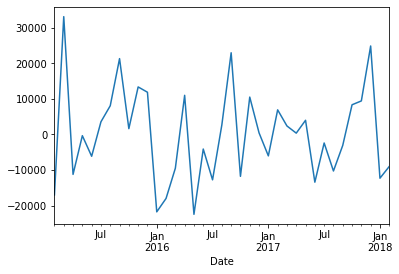

In [680]:
ARIMA_M.resid.plot()

<AxesSubplot:ylabel='Density'>

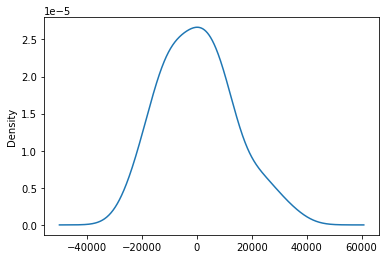

In [681]:
ARIMA_M.resid.plot(kind="kde")

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

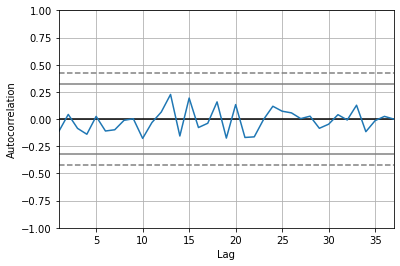

In [682]:
autocorrelation_plot(ARIMA_M.resid)

In [683]:
PreARIMA = pd.DataFrame(ARIMA_M.forecast(steps=10)[0],index=test.index)
PreARIMA.columns = ["ARIMA RESULT"]

In [684]:
print("ARIMA",MAPE(test,PreARIMA))

ARIMA 0.2076723165282351


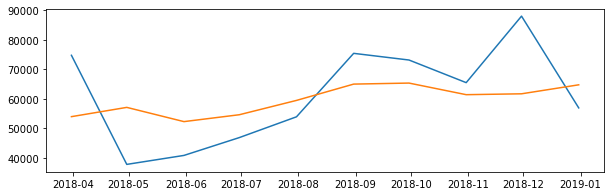

In [685]:
plt.figure(figsize=(10,3))
plt.plot(test)
plt.plot(PreARIMA)

In [686]:
concat0 = [PreARIMA,test]

In [687]:
pd.concat(concat0,axis=1)

,ARIMA RESULT,Sales
Date,,
2018-03-31,53996.101728,74748.6238
2018-04-30,57131.846257,37849.2156
2018-05-31,52316.263592,40882.4464
2018-06-30,54644.411256,46912.8475
2018-07-31,59489.196524,53942.7755
2018-08-31,65007.270190,75408.7840
2018-09-30,65354.452686,73153.3640
2018-10-31,61428.612207,65501.1622
2018-11-30,61724.881928,87997.6400


In [690]:
pd.DataFrame(ARIMA_M.forecast(steps=10)[0],columns=["ARIMA"],index=F_Date.index)

,ARIMA
2019-01-31,53996.101728
2019-02-28,57131.846257
2019-03-31,52316.263592
2019-04-30,54644.411256
2019-05-31,59489.196524
2019-06-30,65007.270190
2019-07-31,65354.452686
2019-08-31,61428.612207
2019-09-30,61724.881928
2019-10-31,64765.356135


# Using SARIMA

In [691]:
SARIMA=sm.tsa.statespace.SARIMAX(train,order=(7, 1, 7),seasonal_order=(1 ,0 ,0 ,12),enforce_stationarity=True,enforce_invertibility=True,trend="n",simple_differencing=False,n_jobs=-1)
SARIMA_R=SARIMA.fit()

In [692]:
SARIMA_R.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Sales   No. Observations:                   38
Model:             SARIMAX(7, 1, 7)x(1, 0, [], 12)   Log Likelihood               -3765.557
Date:                             Mon, 02 May 2022   AIC                           7563.115
Time:                                     14:09:50   BIC                           7588.890
Sample:                                 01-31-2015   HQIC                          7572.202
                                      - 02-28-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5174      0.001   -588.521      0.000      -0.519      -0.516
ar.L2         -0.2250      0.001   -414.690      0.000      -0.226      -0.224
ar.L3         -0.6972      0.001  -1142.233      0.000      -0.698      -0.696
ar.L4         -0.7202      0.001  -1352.634      0.000      -0.721      -0.719
ar.L5         -0.1921      0.000   -479.629      0.000      -0.193      -0.191
ar.L6         -0.5619      0.001   -608.235      0.000      -0.564      -0.560
ar.L7         -0.9642      0.000  -3215.191      0.000      -0.965      -0.964
ma.L1         -0.2878      0.134     -2.148      0.032      -0.550      -0.025
ma.L2          0.2973      0.153      1.941      0.052      -0.003       0.597
ma.L3          0.1951      0.023      8.340      0.000       0.149       0.241
ma.L4         -0.1664      0.022     -7.437      0.000      -0.210      -0.123
ma.L5         -0.2735      0.155     -1.767      0.077      -0.577       0.030
ma.L6          0.3192      0.131      2.430      0.015       0.062       0.577
ma.L7         -0.9789      0.002   -416.616      0.000      -0.984      -0.974
ar.S.L12       0.9959      0.000   9732.029      0.000       0.996       0.996
sigma2      2.677e+05   1.61e-05   1.66e+10      0.000    2.68e+05    2.68e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):                 1.51
Prob(Q):                              0.47   Prob(JB):                         0.47
Heteroskedasticity (H):              12.14   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.9e+24. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='Date'>

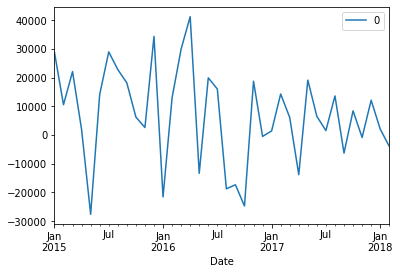

In [693]:
pd.DataFrame(SARIMA_R.resid).plot()

count       38.000000
mean      7015.273729
std      16807.198259
min     -27637.232529
25%       -752.139822
50%       7478.559993
75%      18608.075807
max      41280.933230
dtype: float64


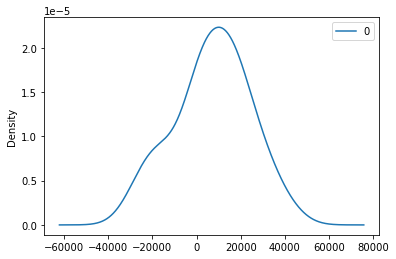

In [694]:
pd.DataFrame(SARIMA_R.resid).plot(kind='kde')
print(SARIMA_R.resid.describe())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

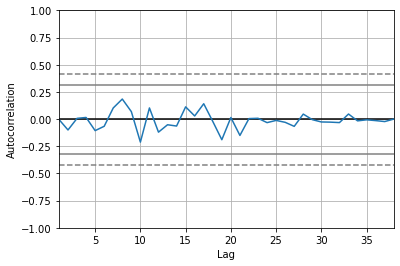

In [695]:
autocorrelation_plot(SARIMA_R.resid)

In [696]:
SARIMA_P = SARIMA_R.forecast(steps=10)

In [697]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [698]:
print("SARIMA",MAPE(test,SARIMA_P))

SARIMA 0.21769677224417397


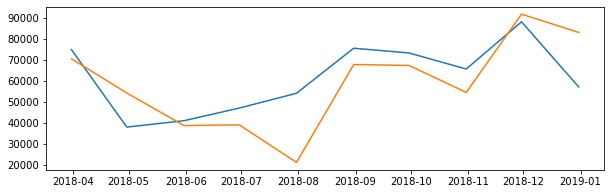

In [699]:
plt.figure(figsize=(10,3))
plt.plot(test)
plt.plot(pd.DataFrame(SARIMA_P))

In [700]:
concat = [SARIMA_P,test]

In [701]:
pd.concat(concat,axis=1)

,predicted_mean,Sales
2018-03-31,70375.824090,74748.6238
2018-04-30,54079.320614,37849.2156
2018-05-31,38563.441654,40882.4464
2018-06-30,38902.428710,46912.8475
2018-07-31,21029.318645,53942.7755
2018-08-31,67635.201083,75408.7840
2018-09-30,67208.460950,73153.3640
2018-10-31,54343.910546,65501.1622
2018-11-30,91648.834903,87997.6400
2018-12-31,82923.955025,56959.2358


In [702]:
pd.DataFrame(SARIMA_R.forecast(steps=25)).tail(15)

,predicted_mean
2019-01-31,63765.661544
2019-02-28,57479.259419
2019-03-31,32770.301066
2019-04-30,59289.364440
2019-05-31,46684.465405
2019-06-30,52196.958183
2019-07-31,51640.903994
2019-08-31,67427.619739
2019-09-30,86637.587749
2019-10-31,74658.223480


### Comparing all the results from our prediction and the test data that was split

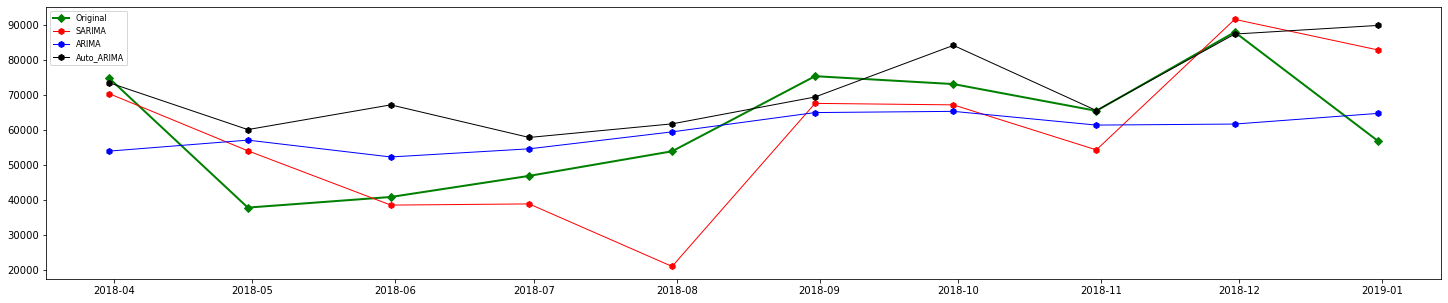

In [703]:
plt.figure(figsize=(25,5))
plt.plot(test,label = "Original",color="Green",linewidth=2, marker='D')
plt.plot(pd.DataFrame(SARIMA_P),label = "SARIMA",color="Red",linewidth=1, marker='h')
plt.plot(PreARIMA,label = "ARIMA",color="Blue",linewidth=1, marker='h')
plt.plot(PreAUTO,label = "Auto_ARIMA",color="BLACK",linewidth=1, marker='h')
plt.legend(loc='upper left', fontsize=8)

### Creating the Data Frame to predict for the future

In [704]:
pred_dates=pd.Series(pd.date_range("1/4/2018", freq="M", periods=24))
pred_dates_ts=pd.DataFrame(index=pred_dates[1:])

In [705]:
pred_dates_ts['ARIMA'] = ARIMA_M.forecast(steps=23)[0]
pred_dates_ts['Auto ARIMA'] = Auto.predict(n_periods=23)

In [706]:
pred = pd.concat([ts,pred_dates_ts],axis=1)

In [707]:
pred["SARIMA"] = SARIMA_R.forecast(steps=25)

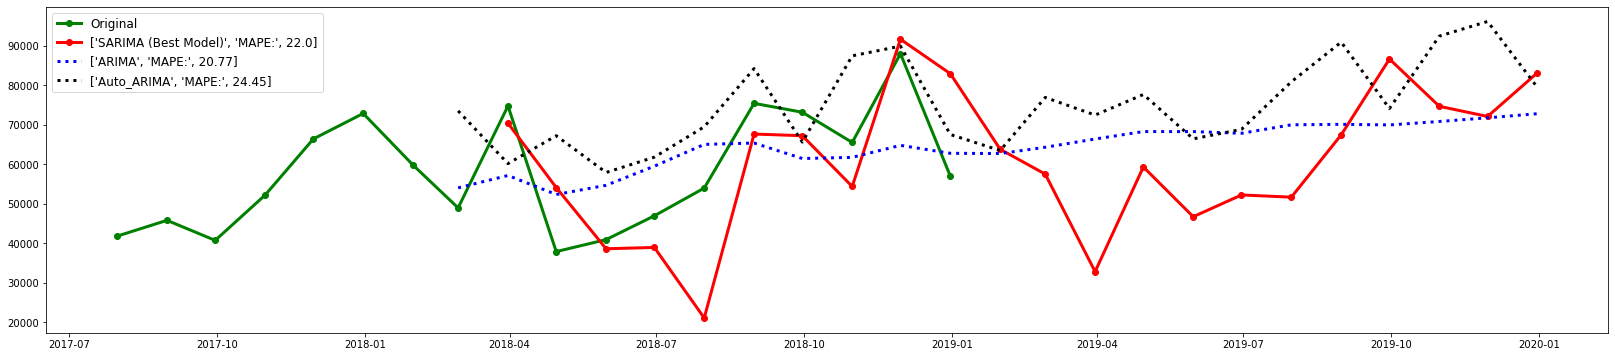

In [708]:
plt.figure(figsize=(28,6))
plt.plot(pred["Sales"].iloc[30:1000],label = "Original",color="Green",linewidth=3,marker = "o")
plt.plot(pred['SARIMA'],label = ["SARIMA (Best Model)","MAPE:",(MAPE(test,SARIMA_P)*100).round()],color="Red",linewidth=3,marker = "o")
plt.plot(pred['ARIMA'],label = ["ARIMA","MAPE:",(MAPE(test,PreARIMA)*100).round(2)],color="Blue",linewidth=3,linestyle=':')
plt.plot(pred['Auto ARIMA'],label = ["Auto_ARIMA","MAPE:",(MAPE(test,PreAUTO)*100).round(2)],color="Black",linewidth=3,linestyle=':')
plt.legend(loc='upper left', fontsize=12)

In [709]:
pred.tail(24)

,Sales,ARIMA,Auto ARIMA,SARIMA
2018-01-31,59767.0910,NaN,NaN,NaN
2018-02-28,48928.8334,53996.101728,73502.824497,NaN
2018-03-31,74748.6238,57131.846257,60143.892645,70375.824090
2018-04-30,37849.2156,52316.263592,67208.624192,54079.320614
2018-05-31,40882.4464,54644.411256,57895.136124,38563.441654
2018-06-30,46912.8475,59489.196524,61778.842505,38902.428710
2018-07-31,53942.7755,65007.270190,69458.846143,21029.318645
2018-08-31,75408.7840,65354.452686,84215.617457,67635.201083
2018-09-30,73153.3640,61428.612207,65587.633916,67208.460950
2018-10-31,65501.1622,61724.881928,87447.064720,54343.910546


In [710]:
pred.to_excel("Results_Superstore_Sales.xlsx")